The motivation is to show the gradient across the array 

In [ ]:
# %%
%load_ext autoreload
%autoreload 2


# %%
import os
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from circuit_toolkit.plot_utils import saveallforms
import seaborn as sns
from os.path import join
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
from core.model_load_utils import load_model_transform, MODEL_LAYER_FILTERS, LAYER_ABBREVIATION_MAPS
from neural_regress.feature_reduction_lib import FEATURE_REDUCTION_DEFAULTS, LAYER_TRANSFORM_FILTERS
from neural_regress.regress_eval_lib import format_result_df, plot_result_df_per_layer, construct_result_df_masked, \
    compute_pred_dict_D2_per_unit, format_result_df_tuple_index
#%% Utility Functions
from core.data_utils import load_from_hdf5, load_neural_data, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths, extract_neural_data_dict_2025apr


encoding_stim_dir = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli/encodingstimuli_apr2025"
dataroot = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Ephys_Data"
model_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/"
# %% [markdown]
# ### Function version of plots

def sweep_combine_result_df(model_output_dir, subject_id, channel_mask=None, model_names=None):
    if model_names is None:
        model_names = [
            "dinov2_vitb14_reg",
            "clipag_vitb32",
            "siglip2_vitb16",
            "radio_v2.5-b",
            "resnet50_robust",
            "resnet50_clip",
            "resnet50_dino",
            "resnet50",
            "regnety_640",
            "AlexNet_training_seed_01",
            # "ReAlnet01",
        ]
    
    top5_chan_result_df_col = []
    for modelname in model_names:
        pred_meta_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
        if not os.path.exists(pred_meta_path):
            print(f"pred_meta_path {pred_meta_path} does not exist, skipping {modelname}")
            continue
        result_df_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV_df.pkl")
        if not os.path.exists(result_df_path):
            print(f"result_df_path {result_df_path} does not exist, skipping {modelname}")
            continue
        
        pred_meta = pkl.load(open(pred_meta_path, "rb"))
        result_df = pd.read_pickle(result_df_path)
        D2_per_unit_train_dict = pred_meta["D2_per_unit_train_dict"]
        D2_per_unit_test_dict = pred_meta["D2_per_unit_test_dict"]
        top5_chan_result_df = construct_result_df_masked(D2_per_unit_train_dict, D2_per_unit_test_dict, mask=channel_mask)
        top5_chan_result_df = format_result_df_tuple_index(top5_chan_result_df, )
        top5_chan_result_df["modelname"] = modelname
        top5_chan_result_df["layer_abbrev"] = top5_chan_result_df["layer"].map(LAYER_ABBREVIATION_MAPS[modelname])
        top5_chan_result_df_col.append(top5_chan_result_df)
    
    if top5_chan_result_df_col:
        return pd.concat(top5_chan_result_df_col, axis=0)
    else:
        return pd.DataFrame()


# %%
# Create a function that returns a figure
def plot_best_per_model(best_per_model, subtitle=f'Best Layer Performance per Model', figsize=(12, 6), descending=True):
    if descending:
        best_per_model = best_per_model.sort_values('test_score', ascending=False)
    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(best_per_model['modelname'], best_per_model['test_score'], color='skyblue')
    ax.set_xlabel('Model')
    ax.set_ylabel('Best Test Score')
    ax.set_title(subtitle)
    plt.xticks(rotation=30, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    # Add the best layer/dimred info as text on top of each bar
    for i, bar in enumerate(bars):
        layer = best_per_model.iloc[i]['layer_abbrev']
        dimred = best_per_model.iloc[i]['dimred']
        score = best_per_model.iloc[i]['test_score']
        
        # Truncate layer name if too long
        if len(layer) > 20:
            layer = layer[:17] + "..."
            
        ax.text(
            bar.get_x() + bar.get_width()/2, 
            bar.get_height() + 0.01, 
            f"{layer}\n{dimred}\n{score:.3f}", 
            ha='center', va='bottom', 
            fontsize=8, rotation=0
        )
    fig.tight_layout()
    return fig

# %%
def plot_model_layer_comparison(result_df, suptitle, rows=3, cols=4, figsize=(20, 15)):
    """
    Create a multi-panel figure with one subplot per model showing test score as function of layer.
    
    Parameters:
    -----------
    result_df : pandas.DataFrame
        DataFrame containing the results with columns: modelname, layer_abbrev, test_score, dimred, regressor
    suptitle : str
        Suptitle for the figure
    rows : int, optional
        Number of rows in the subplot grid (default: 3)
    cols : int, optional
        Number of columns in the subplot grid (default: 4)
    figsize : tuple, optional
        Figure size in inches (width, height) (default: (20, 15))
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    # Create a multi-panel figure with one subplot per model showing test score as function of layer
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True, sharey='all')
    axes = axes.flatten()
    
    # Get unique models
    models = result_df['modelname'].unique()
    
    # Plot each model in its own subplot
    for i, model in enumerate(models):
        if i >= len(axes):  # Skip if we have more models than subplots
            break
        ax = axes[i]
        sns.lineplot(
            data=result_df.query("modelname == @model"),
            x='layer_abbrev', y='test_score', hue='dimred', style='regressor',
            marker='o', markersize=8, linewidth=2,
            ax=ax, 
        )
        ax.grid(True)
        ax.set_title(model, fontsize=14)
        ax.set_xlabel('Layer')
        ax.set_ylabel('Test Score (R²)')
        # Ensure y-axis ticks are visible
        ax.tick_params(axis='y', which='both', left=True, labelleft=True)
        # ax.set_ylim(0, layer_scores['test_score'].max() * 1.1)  # Add 10% padding
        # rotate and align in one go
        ax.tick_params(axis='x', rotation=40)        # rotate them
        for lbl in ax.get_xticklabels():             # grab the Text objects
            lbl.set_ha('right')                      # set horizontal alignment

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(suptitle, 
                 fontsize=16, y=0.98)
    plt.tight_layout()
    
    return fig


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
def format_result_df_all_chan(D2_per_unit_train_dict, D2_per_unit_test_dict):
    index = list(D2_per_unit_train_dict.keys())
    # Create a list to store dataframes for each layer/dimred/regressor
    df_list = []
    for layer_dimred_regressor_idx in index:
        D2_per_unit_train_masked = D2_per_unit_train_dict[layer_dimred_regressor_idx]
        D2_per_unit_test_masked = D2_per_unit_test_dict[layer_dimred_regressor_idx]
        chan_num = len(D2_per_unit_train_masked)
        # Create a dataframe for this layer with one row per channel
        (layername, dimred), regressor = layer_dimred_regressor_idx
        channel_df = pd.DataFrame({
            # 'layer_dimred_regressor': [layer_dimred_regressor_idx] * chan_num,
            'layer': [layername] * chan_num,
            'dimred': [dimred] * chan_num,
            'regressor': [regressor] * chan_num,
            'channel': np.arange(chan_num),
            'train_score': D2_per_unit_train_masked,
            'test_score': D2_per_unit_test_masked,
            'layer_dimred': f"{layername}_{dimred}"
        })
        
        # Add to our list of dataframes
        df_list.append(channel_df)

    # Concatenate all dataframes into one long dataframe
    result_df_all_chan = pd.concat(df_list, axis=0, ignore_index=True)
    return result_df_all_chan


In [81]:
subject_id, filename = ("venus_250426-250429", "venus_250426-250429_vvs-encodingstimuli_z1_rw80-250.h5")
model_output_dir = join(model_root, subject_id, "model_outputs_pca4all")
h5_path = join(dataroot, filename)
data_full = load_from_hdf5(h5_path)
data_dict = extract_neural_data_dict_2025apr(data_full)

In [94]:
brain_area = data_full['neuron_metadata']['brain_area']
channel_depth = data_full['neuron_metadata']['channel_depth']

In [87]:
channel_depth

array([ 0.  ,  3.84,  7.7 , 11.54, 15.4 , 19.24, 23.1 , 26.94, 30.8 ,
       34.64, 38.5 , 42.34,  0.12,  3.96,  7.82, 11.66, 15.52, 19.36,
       23.22, 27.06, 30.92, 34.76, 38.62, 42.46,  0.24,  4.08,  7.94,
       11.78, 15.64, 19.48, 23.34, 27.18, 31.04, 34.88, 38.74, 42.58,
        0.36,  4.2 ,  8.06, 11.9 , 15.76, 19.6 , 23.46, 27.3 , 31.16,
       35.  , 38.86, 42.7 ,  0.48,  4.32,  8.18, 12.02, 15.88, 19.72,
       23.58, 27.42, 31.28, 35.12, 38.98, 42.82,  0.6 ,  4.44,  8.3 ,
       12.14, 16.  , 19.84, 23.7 , 27.54, 31.4 , 35.24, 39.1 , 42.94,
        0.72,  4.56,  8.42, 12.26, 16.12, 19.96, 23.82, 27.66, 31.52,
       35.36, 39.22, 43.06,  0.84,  4.68,  8.54, 12.38, 16.24, 20.08,
       23.94, 27.78, 31.64, 35.48, 39.34, 43.18,  0.96,  4.8 ,  8.66,
       12.5 , 16.36, 20.2 , 24.06, 27.9 , 31.76, 35.6 , 39.46, 43.3 ,
        1.08,  4.92,  8.78, 12.62, 16.48, 20.32, 24.18, 28.02, 31.88,
       35.72, 39.58, 43.42,  1.2 ,  5.04,  8.9 , 12.74, 16.6 , 20.44,
       24.3 , 28.14,

In [32]:
subject_id, filename = ("venus_250426-250429", "venus_250426-250429_vvs-encodingstimuli_z1_rw80-250.h5")
model_output_dir = join(model_root, subject_id, "model_outputs_pca4all")
# if model_names is None:
model_names = [
    "dinov2_vitb14_reg",
    "clipag_vitb32",
    "siglip2_vitb16",
    "radio_v2.5-b",
    "resnet50_robust",
    "resnet50_clip",
    "resnet50_dino",
    "resnet50",
    "regnety_640",
    "AlexNet_training_seed_01",
    # "ReAlnet01",
]

all_chan_result_df_col = []
for modelname in model_names:
    pred_meta_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
    if not os.path.exists(pred_meta_path):
        print(f"pred_meta_path {pred_meta_path} does not exist, skipping {modelname}")
        continue
    result_df_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV_df.pkl")
    if not os.path.exists(result_df_path):
        print(f"result_df_path {result_df_path} does not exist, skipping {modelname}")
        continue
    
    pred_meta = pkl.load(open(pred_meta_path, "rb"))
    result_df = pd.read_pickle(result_df_path)
    D2_per_unit_train_dict = pred_meta["D2_per_unit_train_dict"]
    D2_per_unit_test_dict = pred_meta["D2_per_unit_test_dict"]
    result_df_all_chan = format_result_df_all_chan(D2_per_unit_train_dict, D2_per_unit_test_dict)
    result_df_all_chan['modelname'] = modelname 
    result_df_all_chan['layer_abbrev'] = result_df_all_chan["layer"].map(LAYER_ABBREVIATION_MAPS[modelname])
    all_chan_result_df_col.append(result_df_all_chan)

all_chan_result_df_col_allmodels = pd.concat(all_chan_result_df_col, axis=0)
# if top5_chan_result_df_col:
#     return pd.concat(top5_chan_result_df_col, axis=0)
# else:
#     return pd.DataFrame()

In [33]:
all_chan_result_df_col_allmodels.shape

(184989, 9)

In [34]:
all_chan_result_df_col_allmodels.head()

,layer,dimred,regressor,channel,train_score,test_score,layer_dimred,modelname,layer_abbrev
0,.blocks.NestedTensorBlock0,pca750,RidgeCV,0,0.000005,-0.016189,.blocks.NestedTensorBlock0_pca750,dinov2_vitb14_reg,B0
1,.blocks.NestedTensorBlock0,pca750,RidgeCV,1,0.004867,-0.001244,.blocks.NestedTensorBlock0_pca750,dinov2_vitb14_reg,B0
2,.blocks.NestedTensorBlock0,pca750,RidgeCV,2,0.315638,0.055783,.blocks.NestedTensorBlock0_pca750,dinov2_vitb14_reg,B0
3,.blocks.NestedTensorBlock0,pca750,RidgeCV,3,0.046043,0.001300,.blocks.NestedTensorBlock0_pca750,dinov2_vitb14_reg,B0
4,.blocks.NestedTensorBlock0,pca750,RidgeCV,4,0.360778,0.054323,.blocks.NestedTensorBlock0_pca750,dinov2_vitb14_reg,B0


In [35]:
all_chan_result_df_col_allmodels.modelname.unique()

array(['dinov2_vitb14_reg', 'clipag_vitb32', 'siglip2_vitb16',
       'radio_v2.5-b', 'resnet50_robust', 'resnet50_clip',
       'resnet50_dino', 'resnet50', 'regnety_640',
       'AlexNet_training_seed_01'], dtype=object)

In [67]:
modelname = "dinov2_vitb14_reg"
model_df = all_chan_result_df_col_allmodels.query("dimred == 'pca750' and modelname == @modelname")
model_df["layer_idx"] = model_df["layer_abbrev"].str.replace("B", "").astype(int)

/tmp/ipykernel_2920011/409388298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df["layer_idx"] = model_df["layer_abbrev"].str.replace("B", "").astype(int)


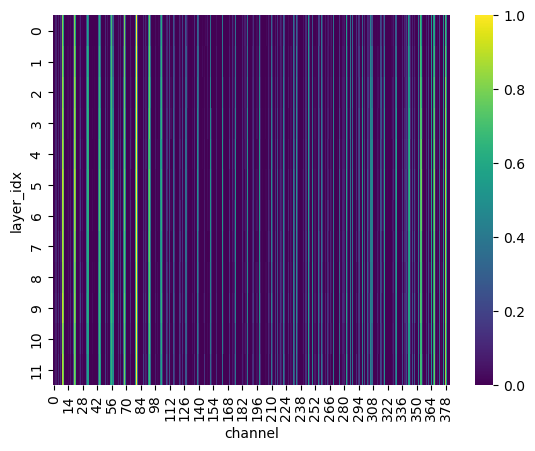

In [49]:
# plot heat map as a function of layer_idx and channel
# Normalize test scores by dividing by the maximum test score for each channel
pivot_data = model_df.pivot(index="layer_idx", columns="channel", values="test_score")
normalized_pivot_data = pivot_data.apply(
    lambda col: col/col.max() if col.max() > 0 else pd.Series(0, index=col.index),
    axis='columns'   # i.e. axis=0: apply to each column
).clip(lower=0)

normalized_pivot_data
sns.heatmap(normalized_pivot_data, cmap="viridis")
plt.show()

In [75]:
synopsis_dir = join(model_root, subject_id, "synopsis")
os.makedirs(synopsis_dir, exist_ok=True)


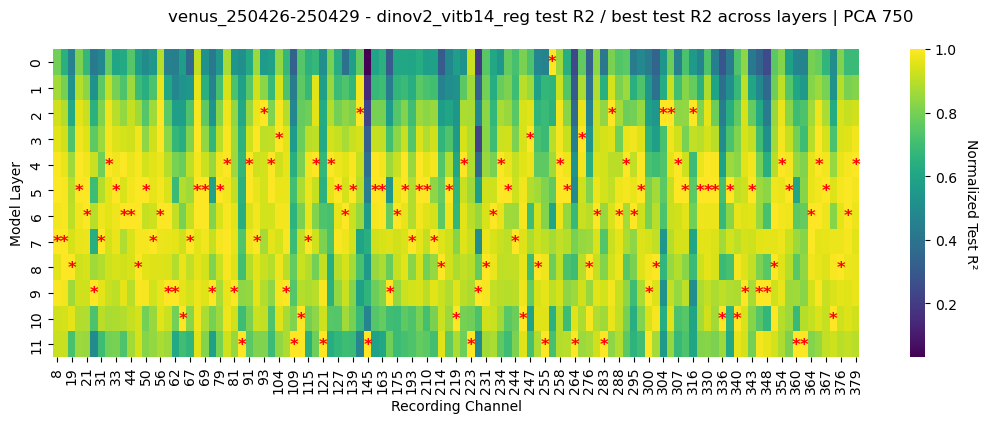

In [76]:
channel_max = pivot_data.max(axis=0)
good_channel_mask = channel_max > 0.10
bad_channel_mask = ~good_channel_mask
normalized_pivot_data = pivot_data.loc[:, good_channel_mask] / channel_max[good_channel_mask]
# plot heat map as a function of layer_idx and channel
# Normalize test scores by dividing by the maximum test score for each channel
fig = plt.figure(figsize=(13., 4))
# Create heatmap
ax = sns.heatmap(normalized_pivot_data.clip(lower=0), cmap="viridis")
plt.xlabel("Recording Channel")
plt.ylabel("Model Layer")
# Find locations where value is 1.0 (or very close to it)
# Add colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label('Normalized Test R²', rotation=270, labelpad=15)
max_locs = np.where(np.isclose(normalized_pivot_data.values, 1.0))
for i, j in zip(max_locs[0], max_locs[1]):
    # Add a red asterisk at each maximum location
    ax.text(j + 0.5, i + 0.5, '*', color='red', fontsize=12, 
            ha='center', va='center', fontweight='bold')
plt.suptitle(f"{subject_id} - {modelname} test R2 / best test R2 across layers | PCA 750")
saveallforms(synopsis_dir, f"{subject_id}_{modelname}_channel_model_layer_heatmap_normalized_R2_pca750", fig)
plt.show()

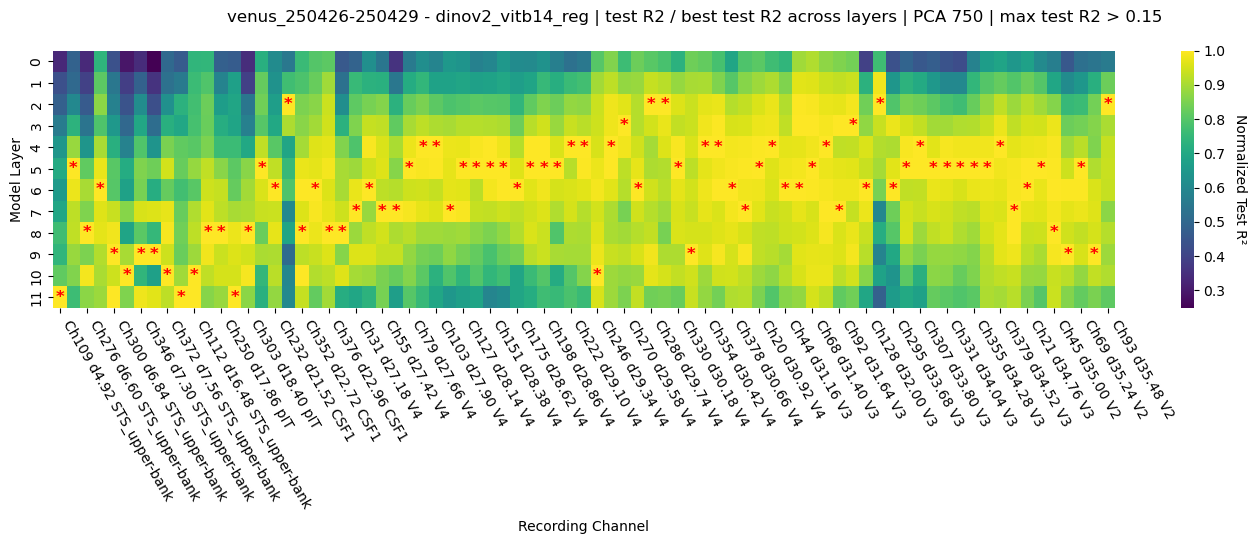

In [116]:
# Get the channel depth values from the channel_depths array
# Reorder the columns of pivot_data based on channel depth
channel_order = np.argsort(channel_depth)
pivot_data = model_df.pivot(index="layer_idx", columns="channel", values="test_score")
pivot_data = pivot_data.reindex(columns=channel_order)
channel_max = pivot_data.max(axis=0)
R2_threshold = 0.15
good_channel_mask = channel_max > R2_threshold
bad_channel_mask = ~good_channel_mask
normalized_pivot_data = pivot_data.loc[:, good_channel_mask] / channel_max[good_channel_mask]
# plot heat map as a function of layer_idx and channel
# Normalize test scores by dividing by the maximum test score for each channel
fig = plt.figure(figsize=(14., 5.5))
# Create heatmap
ax = sns.heatmap(normalized_pivot_data.clip(lower=0), cmap="viridis")
plt.xlabel("Recording Channel")
plt.ylabel("Model Layer")
# Add colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label('Normalized Test R²', rotation=270, labelpad=15)
# Find locations where value is 1.0 (or very close to it)
max_locs = np.where(np.isclose(normalized_pivot_data.values, 1.0))
for i, j in zip(max_locs[0], max_locs[1]):
    # Add a red asterisk at each maximum location
    ax.text(j + 0.5, i + 0.5, '*', color='red', fontsize=12, 
            ha='center', va='center', fontweight='bold')
# Change the xtick labels to add annotation of brain area and channel depth
xticklabels_old = ax.get_xticklabels()
xticklabels_new = []
for i, label in enumerate(xticklabels_old):
    # get old label text
    old_text = label.get_text()
    channel_idx = int(old_text.split(" ")[-1])
    # get brain area and channel depth
    brain_area_ = brain_area[channel_idx].decode("utf-8")
    channel_depth_ = channel_depth[channel_idx]
    label.set_text(f"Ch{channel_idx} d{channel_depth_:.2f} {brain_area_} ")
    xticklabels_new.append(label)
ax.set_xticklabels(xticklabels_new, rotation=-60, ha='left')

# Adjust figure layout to make room for the longer labels
plt.suptitle(f"{subject_id} - {modelname} | test R2 / best test R2 across layers | PCA 750 | max test R2 > {R2_threshold}")
plt.tight_layout()
saveallforms(synopsis_dir, f"{subject_id}_{modelname}_channel_model_layer_heatmap_normalized_R2_pca750_area_depth_annot", fig)
plt.show()

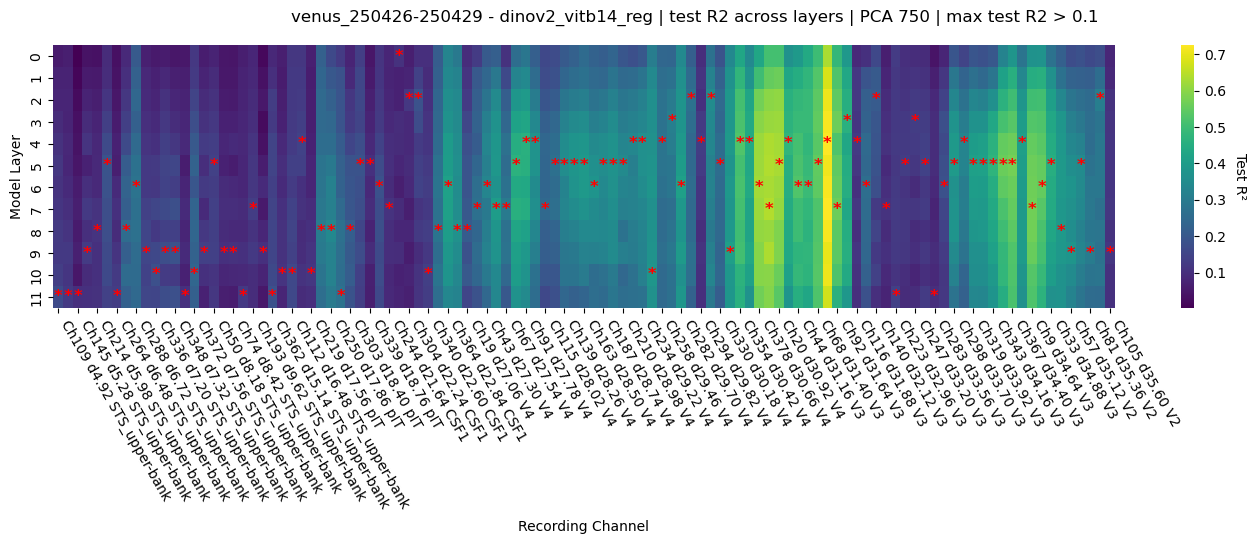

In [ ]:
# Get the channel depth values from the channel_depths array
# Reorder the columns of pivot_data based on channel depth
channel_order = np.argsort(channel_depth)
pivot_data = model_df.pivot(index="layer_idx", columns="channel", values="test_score")
pivot_data = pivot_data.reindex(columns=channel_order)
channel_max = pivot_data.max(axis=0)
good_channel_mask = channel_max > 0.10
bad_channel_mask = ~good_channel_mask
normalized_pivot_data = pivot_data.loc[:, good_channel_mask] / channel_max[good_channel_mask]
# plot heat map as a function of layer_idx and channel
# Normalize test scores by dividing by the maximum test score for each channel
fig = plt.figure(figsize=(14., 5.5))
# Create heatmap
ax = sns.heatmap(pivot_data.loc[:, good_channel_mask].clip(lower=0), cmap="viridis")
plt.xlabel("Recording Channel")
plt.ylabel("Model Layer")
# Add colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label('Test R²', rotation=270, labelpad=15)
# Find locations where value is 1.0 (or very close to it)
max_locs = np.where(np.isclose(normalized_pivot_data.values, 1.0))
for i, j in zip(max_locs[0], max_locs[1]):
    # Add a red asterisk at each maximum location
    ax.text(j + 0.5, i + 0.5, '*', color='red', fontsize=12, 
            ha='center', va='center', fontweight='bold')
# Change the xtick labels to add annotation of brain area and channel depth
xticklabels_old = ax.get_xticklabels()
xticklabels_new = []
for i, label in enumerate(xticklabels_old):
    # get old label text
    old_text = label.get_text()
    channel_idx = int(old_text.split(" ")[-1])
    # get brain area and channel depth
    brain_area_ = brain_area[channel_idx].decode("utf-8")
    channel_depth_ = channel_depth[channel_idx]
    label.set_text(f"Ch{channel_idx} d{channel_depth_:.2f} {brain_area_} ")
    xticklabels_new.append(label)
ax.set_xticklabels(xticklabels_new, rotation=-60, ha='left')

# Adjust figure layout to make room for the longer labels
plt.suptitle(f"{subject_id} - {modelname} | test R2 across layers | PCA 750 | max test R2 > 0.1")
plt.tight_layout()
saveallforms(synopsis_dir, f"{subject_id}_{modelname}_channel_model_layer_heatmap_test_R2_pca750_area_depth_annot", fig)
plt.show()

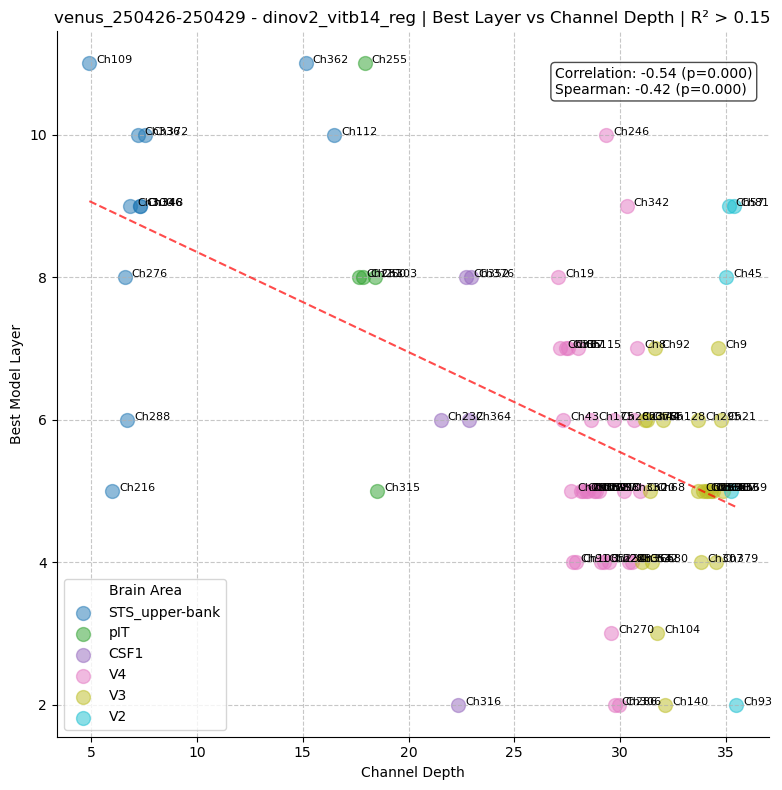

In [131]:
from scipy.stats import pearsonr, spearmanr
# Create a plot showing channel depth as a function of the best layer with best test R2
pivot_data = model_df.pivot(index="layer_idx", columns="channel", values="test_score")
# First, find the layer with the best test R2 for each channel
best_layer_per_channel = pivot_data.idxmax()
# Create a dataframe with channel, best layer, and channel depth
best_layer_df = pd.DataFrame({
    'channel': best_layer_per_channel.index,
    'best_layer': best_layer_per_channel.values,
    'channel_depth': [channel_depth[ch] for ch in best_layer_per_channel.index],
    'test_r2': [pivot_data.loc[best_layer_per_channel[ch], ch] for ch in best_layer_per_channel.index],
    'brain_area': [brain_area[ch].decode('utf-8') for ch in best_layer_per_channel.index]
})
# Filter to only include channels with good R2 scores
best_layer_df = best_layer_df.query("test_r2 > @R2_threshold")
# Sort by channel depth
best_layer_df = best_layer_df.sort_values('channel_depth')
# Create a scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
# Create a colormap for different brain areas
unique_areas = best_layer_df['brain_area'].unique()
area_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_areas)))
area_color_map = dict(zip(unique_areas, area_colors))
# Plot each point, colored by brain area
for area in unique_areas:
    area_data = best_layer_df[best_layer_df['brain_area'] == area]
    ax.scatter(area_data['channel_depth'], area_data['best_layer'], 
               label=area, alpha=0.5, s=100, 
               color=area_color_map[area])

# Add channel numbers as annotations
for _, row in best_layer_df.iterrows():
    ax.annotate(f"Ch{row['channel']}", 
                (row['channel_depth'], row['best_layer']),
                xytext=(5, 0), textcoords='offset points',
                fontsize=8)

# Add a trend line
if len(best_layer_df) > 1:
    z = np.polyfit(best_layer_df['channel_depth'], best_layer_df['best_layer'], 1)
    p = np.poly1d(z)
    ax.plot(np.sort(best_layer_df['channel_depth']), 
            p(np.sort(best_layer_df['channel_depth'])), 
            "r--", alpha=0.7)
    # Calculate correlation
    corr, p_val = pearsonr(best_layer_df['channel_depth'], best_layer_df['best_layer'])
    spearman_corr, spearman_p_val = spearmanr(best_layer_df['channel_depth'], best_layer_df['best_layer'])
    ax.text(0.70, 0.95, f"Correlation: {corr:.2f} (p={p_val:.3f})\nSpearman: {spearman_corr:.2f} (p={spearman_p_val:.3f})", 
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
# Add labels and title
ax.set_xlabel('Channel Depth')
ax.set_ylabel('Best Model Layer')
ax.set_title(f"{subject_id} - {modelname} | Best Layer vs Channel Depth | R² > {R2_threshold}")
# Add legend
ax.legend(title="Brain Area", loc='best')
# Add grid
ax.grid(True, linestyle='--', alpha=0.7)
# Adjust layout
plt.tight_layout()
saveallforms(synopsis_dir, f"{subject_id}_{modelname}_best_layer_vs_channel_depth_corr_R2_{R2_threshold}", fig)
plt.show()


### Scratch

In [2]:
subject_id, filename = ("venus_250426-250429", "venus_250426-250429_vvs-encodingstimuli_z1_rw80-250.h5")
data_path = join(dataroot, filename)
model_output_dir = join(model_root, subject_id, "model_outputs_pca4all")
synopsis_dir = join(model_root, subject_id, "synopsis")
os.makedirs(synopsis_dir, exist_ok=True)
data_dict = extract_neural_data_dict_2025apr(load_from_hdf5(data_path))
reliability = data_dict['reliability']
# Get the top 5 channels with highest reliability
topk = 5
topk_indices = np.argsort(reliability)[-topk:]
# Create a binary mask for these top 5 channels
top5_channel_mask = np.zeros_like(reliability, dtype=bool)
top5_channel_mask[topk_indices] = True
all_channel_mask = np.ones_like(reliability, dtype=bool)
for channel_mask, mask_label in [(top5_channel_mask, "top5_reliab"), 
                                (all_channel_mask, "all")]:
    # Report the threshold as the lowest reliability value among the top 5
    threshold = reliability[channel_mask].min()
    print(f"Using top 5 channels with reliability threshold: {threshold:.3f}")
    top5_chan_result_df = sweep_combine_result_df(model_output_dir, subject_id, channel_mask)
    top5_chan_result_df.to_csv(join(synopsis_dir, f"{subject_id}_{mask_label}_chan_all_models_result_df_synopsis_reliability_{threshold}.csv"))


In [ ]:
# %% [markdown]
# ### Other monkeys
# Use the function with reliability threshold
subject_id, filename = "paul_20250428-20250430", "paul_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5"

for subject_id, filename in [
    # ("red_20250428-20240429", "red_20250428-20240429_vvs-encodingstimuli_z1_rw100-400.h5"),
    # ("red_20250428-20250430", "red_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5"), 
    # ("paul_20250428-20250430", "paul_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5"), 
    # ("three0_250426-250430", "three0_250426-250430_vvs-encodingstimuli_z1_rw80-250.h5"), 
    ("venus_250426-250429", "venus_250426-250429_vvs-encodingstimuli_z1_rw80-250.h5"), 
    # ("three0_250426-250501", "three0_250426-250501_vvs-encodingstimuli_z1_rw80-250.h5"),
    # ("leap_250426-250501", "leap_250426-250501_vvs-encodingstimuli_z1_rw80-250.h5"),
]:
    data_path = join(dataroot, filename)
    model_output_dir = join(model_root, subject_id, "model_outputs_pca4all")
    synopsis_dir = join(model_root, subject_id, "synopsis")
    os.makedirs(synopsis_dir, exist_ok=True)
    data_dict = extract_neural_data_dict_2025apr(load_from_hdf5(data_path))
    reliability = data_dict['reliability']
    # Get the top 5 channels with highest reliability
    topk = 5
    topk_indices = np.argsort(reliability)[-topk:]
    # Create a binary mask for these top 5 channels
    top5_channel_mask = np.zeros_like(reliability, dtype=bool)
    top5_channel_mask[topk_indices] = True
    all_channel_mask = np.ones_like(reliability, dtype=bool)
    for channel_mask, mask_label in [(top5_channel_mask, "top5_reliab"), 
                                    (all_channel_mask, "all")]:
        # Report the threshold as the lowest reliability value among the top 5
        threshold = reliability[channel_mask].min()
        print(f"Using top 5 channels with reliability threshold: {threshold:.3f}")
        top5_chan_result_df = sweep_combine_result_df(model_output_dir, subject_id, channel_mask)
        top5_chan_result_df.to_csv(join(synopsis_dir, f"{subject_id}_{mask_label}_chan_all_models_result_df_synopsis_reliability_{threshold}.csv"))

        # %
        # Find the best layer/dimred/regressor combination for each model
        best_per_model = top5_chan_result_df.query("'pca750' in dimred").groupby('modelname').apply(
            lambda x: x.loc[x['test_score'].idxmax()]
        ).reset_index(drop=True)
        # Generate and display the figure
        fig = plot_best_per_model(best_per_model, f"{subject_id} - best regressor test R2 - All layers PCA only | Reliability > {threshold:.3f} (N={channel_mask.sum()})")
        saveallforms(synopsis_dir, f"{subject_id}_{mask_label}_chan_model_comparison_best_pca750", fig)
        plt.show()

        # Find the best layer/dimred/regressor combination for each model
        best_per_model = top5_chan_result_df.groupby('modelname').apply(
            lambda x: x.loc[x['test_score'].idxmax()]
        ).reset_index(drop=True)
        # Generate and display the figure
        fig = plot_best_per_model(best_per_model, f"{subject_id} - best regressor test R2 - All layers any dimred | Reliability > {threshold:.3f} (N={channel_mask.sum()})")
        saveallforms(synopsis_dir, f"{subject_id}_{mask_label}_chan_model_comparison_best_anydimred", fig)
        plt.show()

        # Example usage:
        fig = plot_model_layer_comparison(top5_chan_result_df, f"{subject_id} - Test Score by Layer Across Models | Reliability > {threshold:.3f} (N={channel_mask.sum()})")
        saveallforms(synopsis_dir, f"{subject_id}_{mask_label}_chan_all_models_comparison_by_layer", fig)
        plt.show()
        

# %%
